# Housing Prices
## Exploration of Advanced Regression Techniques and Feature Selection
### Robin Lashof-Regas

## Introduction
In this project I explore a number of regression techniques to try to estimate SalePrice of homes given a number of both categorical and numerical features. The problem and dataset used come from the [House Prices: Advanced Regression Techniques Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). The main focus of my project was to explore the tradeoffs of various techniques of feature extraction/selection, as well as the relative accuracies of various models compared to the amount of effort needed to tune and fit those models. 

First I perform some basic EDA on the dataset to understand the different features and distributions thereof. Next, I use my EDA to go through the arduous process of manual feature extraction and create a preprocessing method to extract important features from the given dataset. Finally I apply various regression techniques to my dataset, compare the results, and perform some error analysis to help understand the strengths and weaknesses of the various models and some possible next steps.

## Imports

In [0]:
# imports
from google.colab import files
import pandas as pd
import io
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import mean_squared_log_error
from math import sqrt, log, exp
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

## Load Data
In this section I load the data and separate out a train and test set. I have chosen to implement my entire analysis using the provided "train.csv" file from the aforementioned kaggle competition so that this notebook can be self contained.

In [3]:
# load data files
# execute this cell and choose train.csv
uploaded = files.upload()

Saving train.csv to train.csv


Here I split the data into train and test sets being sure to randomize the order of data rows.

In [0]:
# load data into dataframes
train_raw = pd.read_csv(io.StringIO(uploaded['train.csv'].decode('utf-8'))).sample(frac=1).reset_index(drop=True)
train_data = train_raw[:1000]
test_data = train_raw[1000:]

## Exploratory Data Analysis
First let's inspect the provided columns to understand what we're dealing with. First I look at the raw data, then the distributions for numeric features, and finally I inspect which features have been loaded in as numeric vs categorical. Next we look at the correlations between the numeric features and look at the distribution of the SalePrice variable to understand what outliers we might have and if any transformations might be needed when we evaluate our models. The provided "data_description.txt" document was also extremely helpful in understanding each column and the expected values.

Please also see Appendix A for some ad hoc EDA done while analyzing each feature individually. This analysis greatly influenced the implementation of the `preprocess_data` method in the next section.

In [0]:
# inspect columns
train_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,809,80,RL,85.0,13400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,SLvl,5,5,1966,1966,Gable,CompShg,VinylSd,VinylSd,BrkFace,1047.0,TA,TA,CBlock,TA,TA,Av,ALQ,516,BLQ,128,380,1024,GasA,...,Y,SBrkr,1086,0,0,1086,1,0,1,0,3,1,TA,6,Typ,1,Gd,Attchd,1966.0,RFn,2,484,TA,TA,Y,0,0,0,0,0,0,NaN,GdWo,NaN,0,6,2006,WD,Normal,159950
1,247,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,Stone,Fa,TA,No,Unf,0,Unf,0,1020,1020,GasA,...,N,FuseP,908,1020,0,1928,0,0,2,0,4,2,Fa,9,Typ,0,NaN,Detchd,1910.0,Unf,1,440,Po,Po,Y,0,60,112,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Normal,137000
2,304,20,RL,70.0,9800,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,1Story,5,7,1972,1972,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,TA,TA,No,ALQ,894,Unf,0,0,894,GasA,...,Y,SBrkr,894,0,0,894,1,0,1,0,3,1,TA,5,Typ,0,NaN,Attchd,1975.0,Unf,2,552,TA,TA,Y,256,0,0,0,0,0,NaN,GdWo,NaN,0,7,2006,WD,Abnorml,149900
3,1236,70,RL,96.0,13132,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,5,5,1914,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,Gd,TA,Mn,Unf,0,Unf,0,747,747,GasA,...,Y,FuseF,892,892,0,1784,0,0,1,1,4,1,TA,9,Typ,0,NaN,Detchd,1914.0,Unf,1,180,Fa,Fa,N,203,40,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal,138887
4,314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,Inside,Sev,Timber,Norm,Norm,1Fam,1Story,7,5,1965,1965,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,1236,Rec,820,80,2136,GasW,...,Y,SBrkr,2036,0,0,2036,2,0,2,0,3,1,TA,8,Typ,2,Gd,Attchd,1965.0,RFn,2,513,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,770,60,RL,47.0,53504,Pave,NaN,IR2,HLS,AllPub,CulDSac,Mod,StoneBr,Norm,Norm,1Fam,2Story,8,5,2003,2003,Hip,CompShg,CemntBd,Wd Shng,BrkFace,603.0,Ex,TA,PConc,Gd,TA,Gd,ALQ,1416,Unf,0,234,1650,GasA,...,Y,SBrkr,1690,1589,0,3279,1,0,3,1,4,1,Ex,12,Mod,1,Gd,BuiltIn,2003.0,Fin,3,841,TA,TA,Y,503,36,0,0,210,0,NaN,NaN,NaN,0,6,2010,WD,Normal,538000
996,938,60,RL,75.0,9675,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,5,2005,2005,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,341,Unf,0,772,1113,GasA,...,Y,SBrkr,1113,858,0,1971,0,0,2,1,3,1,Gd,8,Typ,1,Gd,Attchd,2005.0,RFn,2,689,TA,TA,Y,0,48,0,0,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal,253000
997,886,120,FV,50.0,5119,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Somerst,Norm,Norm,TwnhsE,1Story,9,5,1999,2000,Gable,CompShg,MetalSd,MetalSd,BrkFace,60.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1238,Unf,0,460,1698,GasA,...,Y,SBrkr,1709,0,0,1709,1,0,2,0,2,1,Gd,5,Typ,1,TA,Attchd,1999.0,Fin,2,506,TA,TA,Y,97,65,0,0,0,0,NaN,NaN,NaN,0,1,2008,CWD,Abnorml,328900
998,20,20,RL,70.0,7560,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1958,1965,Hip,CompShg,BrkFace,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,LwQ,504,Unf,0,525

In [0]:
# inspect column distributions
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1000.000000,1000.000000,820.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,995.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,938.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,731.149000,56.720000,69.760976,10557.057000,6.065000,5.583000,1970.276000,1984.604000,101.298492,446.195000,45.155000,553.737000,1045.087000,1152.649000,344.057000,7.395000,1504.101000,0.430000,0.060000,1.551000,0.371000,2.856000,1.046000,6.469000,0.613000,1978.218550,1.740000,466.253000,90.464000,46.349000,23.992000,3.984000,15.4740,2.804000,49.084000,6.292000,2007.839000,178467.699000
std,427.784718,42.082806,25.178657,10012.496146,1.373558,1.136839,30.362142,20.774233,182.550526,467.839469,158.652815,430.108052,451.157392,391.558317,433.192007,55.279044,532.870338,0.526666,0.245887,0.558311,0.501608,0.837834,0.223459,1.635149,0.647804,24.623054,0.751642,215.200935,122.383219,68.150214,64.480366,32.593006,56.2086,40.103864,535.086623,2.687743,1.341223,79176.267449
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1875.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,372.000000,0.000000,0.000000,438.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1906.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,349.750000,20.000000,57.000000,7500.000000,5.000000,5.000000,1952.000000,1966.000000,0.000000,0.000000,0.000000,215.000000,780.000000,864.000000,0.000000,0.000000,1113.750000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,312.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,5.000000,2007.000000,128375.000000
50%,741.500000,50.000000,68.000000,9451.000000,6.000000,5.000000,1972.000000,1993.000000,0.000000,370.500000,0.000000,469.000000,973.500000,1070.500000,0.000000,0.000000,1456.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,474.000000,0.000000,24.000000,0.000000,0.000000,0.0000,0.000000,0.000000,6.000000,2008.000000,161750.000000
75%,1109.250000,70.000000,80.000000,11648.250000,7.000000,6.000000,2000.000000,2004.000000,153.500000,712.250000,0.000000,794.250000,1291.500000,1391.250000,720.000000,0.000000,1751.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,165.000000,66.000000,0.000000,0.000000,0.0000,0.000000,0.000000,8.000000,2009.000000,211250.000000
max,1459.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2121.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.0000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [0]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 81 columns):
Id               1000 non-null int64
MSSubClass       1000 non-null int64
MSZoning         1000 non-null object
LotFrontage      820 non-null float64
LotArea          1000 non-null int64
Street           1000 non-null object
Alley            67 non-null object
LotShape         1000 non-null object
LandContour      1000 non-null object
Utilities        1000 non-null object
LotConfig        1000 non-null object
LandSlope        1000 non-null object
Neighborhood     1000 non-null object
Condition1       1000 non-null object
Condition2       1000 non-null object
BldgType         1000 non-null object
HouseStyle       1000 non-null object
OverallQual      1000 non-null int64
OverallCond      1000 non-null int64
YearBuilt        1000 non-null int64
YearRemodAdd     1000 non-null int64
RoofStyle        1000 non-null object
RoofMatl         1000 non-null object
Exterior1st      1000 non-nul

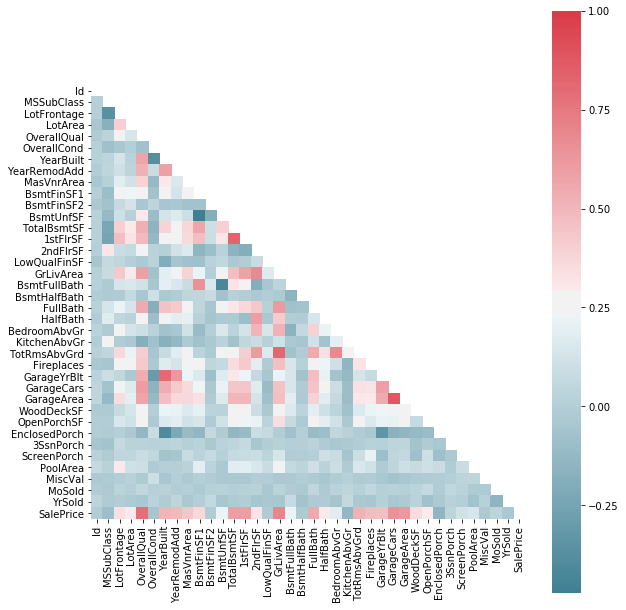

In [0]:
# make heatmap of correllations
corr = train_data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(9, 9))
cmap = sb.diverging_palette(220, 10, as_cmap=True)
sb.heatmap(corr, mask=mask, cmap=cmap, ax=ax,  square=True)
fig.tight_layout()

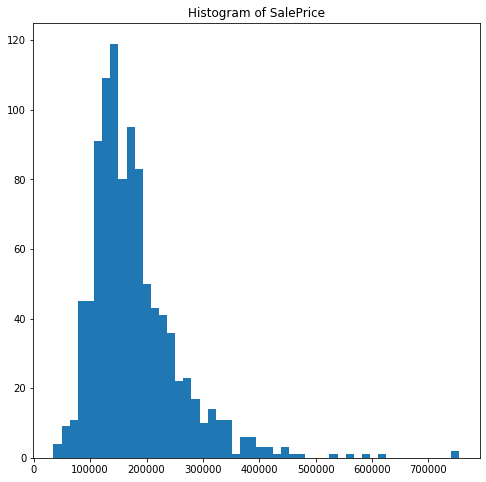

In [0]:
# histogram of target to check for major outliers or strange distributions
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.hist(train_data['SalePrice'], bins=50)
ax.set_title('Histogram of SalePrice')
fig.show()

## Feature Extraction
The following methods display the techniques I used for feature extraction. The first step for each feature was to determine whether and ordinal encoding was warranted or whether a one-hot encoding should be implemented instead. This is where it became very clear that domain knowledge is quite important. For example, the "RoofStyle" and "RoofMatl" variables contained many roof styles and materials that likely, to a trained eye, have an obvious ordinal structure based on customer demand. Not being a real estate expert, I was forced to use a one-hot encoding for these features which loses out on some of the details contained within them. Other features had obvious ordinal categories that I used to extract numerical features that represent the categories quite well. Finally, a few features could be combined or reduced to create more interesting "score" type variables that capture additional info from these categorical features. One example is displayed below where the "Condition1" and "Condition2" fields can be processed into proximity scores that capture a property's proximity to positive or negative points of interest.

In the next section we will compare models using these extracted features compared to using a simple one-hot encoding for all categorical features.

In [0]:
def get_pos_prox_score(x):
  pos = 0
  if(x['Condition1'] == 'PosA'  or x['Condition2'] == 'PosA'):
    pos = 2
  elif(x['Condition1'] == 'PosN'  or x['Condition2'] == 'PosN'):
    pos = 1
  return pos

def get_neg_prox_score(x):
  neg = 0
  if(x['Condition1'] == 'RRAn' or x['Condition1'] == 'RRAe'  or x['Condition2'] == 'RRAn' or x['Condition2'] == 'RRAe'):
    neg = 2
  elif(x['Condition1'] == 'RRNn' or x['Condition1'] == 'RRNe'  or x['Condition2'] == 'RRNn' or x['Condition2'] == 'RRNe'):
    neg = 1
  return neg

def preprocess_data(df):
  train_data = df.copy()
  one_hot_cols = ['MSSubClass', 'Neighborhood', 'RoofStyle', 'RoofMatl', 
                  'BsmtFinType1', 'BsmtFinType2', 'Heating', 'GarageType',
                  'MiscFeature', 'SaleType', 'SaleCondition']
  dropCols = ['Id', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 
              'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2',
              'BldgType', 'HouseStyle', 'Exterior1st', 'Exterior2nd', 
              'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
              'BsmtCond', 'BsmtExposure', 'TotalBsmtSF', 'HeatingQC', 'CentralAir',
              'Electrical', 'KitchenQual', 'FireplaceQu', 'Functional', 'GarageQual',
              'GarageCond', 'GarageFinish', 'PavedDrive', 'PoolQC', 'Fence'] 

  le = LabelEncoder()

  # create two new features from MSZoning column
  res_zones = ['FV','RH','RL','RP','RM']
  train_data['ResZoned'] = train_data['MSZoning'].isin(res_zones)
  train_data['Density'] = train_data.apply(lambda x: 4, axis= 1)
  train_data.loc[train_data['MSZoning'].isin(['RL', 'RP', 'A']), 'Density'] = 1
  train_data.loc[train_data['MSZoning'].isin(['RM', 'FV']), 'Density'] = 2
  train_data.loc[train_data['MSZoning'] == 'RH', 'Density'] = 3

  # street just has two possible values
  train_data['RoadType'] = train_data[['Street']].apply(lambda col: le.fit_transform(col))

  # add feature based on has alley, what type probably doesn't matter
  train_data['HasAlley'] = train_data['Alley'].isin(['Grvl','Pave'])

  # ordered feature for lot shape
  oeShape = OrdinalEncoder(categories=[['Reg', 'IR1', 'IR2', 'IR3']])
  train_data['Shape'] = oeShape.fit_transform(train_data[['LotShape']])

  # ordered feature for what utilities are available
  oeUtil = OrdinalEncoder(categories=[['ELO', 'NoSeWa', 'NoSewr', 'AllPub']])
  train_data['Utils'] = oeUtil.fit_transform(train_data[['Utilities']])

  # two new features based on lot_config
  train_data['IsCulDSac'] = train_data['LotConfig'] == 'CulDSac'
  train_data['HasFrontage'] = train_data['LotConfig'].isin(['FR2', 'FR3'])

  # ordered feature for lot slope
  oeSlope = OrdinalEncoder(categories=[['Gtl', 'Mod', 'Sev']])
  train_data['Slope'] = oeSlope.fit_transform(train_data[['LandSlope']])

  # get two new features for proximity
  train_data['PosProxScore'] = train_data.apply(lambda x: get_pos_prox_score(x), axis=1)
  train_data['NegProxScore'] = train_data.apply(lambda x: get_neg_prox_score(x), axis=1)

  # get new feature for building type while fixing incorrect labels
  oeBldg = OrdinalEncoder(categories=[['2FmCon', 'TwnhsI', 'TwnhsE', 'Duplx', '1Fam']])
  train_data.loc[train_data['BldgType'] == '2fmCon', 'BldgType'] = '2FmCon'
  train_data.loc[train_data['BldgType'] == 'Twnhs', 'BldgType'] = 'TwnhsI'
  train_data.loc[train_data['BldgType'] == 'Duplex', 'BldgType'] = 'Duplx'
  train_data['Bldg'] = oeBldg.fit_transform(train_data[['BldgType']])

  # ordered feature for house style
  oeHouse = OrdinalEncoder(categories=[['1Story', '1.5Unf', '1.5Fin', 'SFoyer', 'SLvl', '2Story', '2.5Unf', '2.5Fin']])
  train_data['House'] = oeHouse.fit_transform(train_data[['HouseStyle']])

  # combine dummies across these two columns (also fix incorrect labels)
  ext_dummies = pd.get_dummies(train_data[['Exterior1st', 'Exterior2nd']], {'Exterior1st': 'Ext', 'Exterior2nd': 'Ext2'}, columns=['Exterior1st', 'Exterior2nd'])
  rmvCols = []
  for col in ext_dummies.columns:
    if 'Ext2' in col:
      mat = col.split('_')[1]
      if mat == 'Brk Cmn':
        mat = 'BrkComm'
      if mat == 'CmentBd':
        mat = 'CemntBd'
      if mat == 'Wd Shng':
        mat = 'WdShing'
      extCol = 'Ext_' + mat
      if extCol not in ext_dummies.columns:
        ext_dummies[extCol] = ext_dummies[col]
      ext_dummies[extCol] = ext_dummies[extCol] | ext_dummies[col]
      rmvCols.append(col)
  ext_dummies.drop(rmvCols, axis=1, inplace=True)
  train_data = pd.concat([train_data, ext_dummies], axis=1)

  # ordered column for masonry
  train_data.loc[train_data['MasVnrType'].isna(), 'MasVnrType'] = 'None'
  oeMasonry = OrdinalEncoder(categories=[['CBlock', 'None', 'BrkCmn', 'BrkFace', 'Stone']])
  train_data['Masonry'] = oeMasonry.fit_transform(train_data[['MasVnrType']])

  # ordered features for exterior qualit/condition
  oeExtQ = OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex']])
  train_data['ExtQual'] = oeExtQ.fit_transform(train_data[['ExterQual']])
  train_data['ExtCond'] = oeExtQ.fit_transform(train_data[['ExterCond']])

  # ordered feature for foundation by mean of SalePrice distribution
  oeFound = OrdinalEncoder(categories=[['Slab', 'BrkTil', 'CBlock', 'Stone', 'Wood', 'PConc']])
  train_data['FoundationMat'] = oeFound.fit_transform(train_data[['Foundation']])

  # ordered features for basement quality and condition
  train_data.loc[train_data['BsmtQual'].isna(), 'BsmtQual'] = 'NA'
  train_data.loc[train_data['BsmtCond'].isna(), 'BsmtCond'] = 'NA'
  oeBsmtQ = OrdinalEncoder(categories=[['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])
  train_data['BsmtQ'] = oeBsmtQ.fit_transform(train_data[['BsmtQual']])
  train_data['BsmtC'] = oeBsmtQ.fit_transform(train_data[['BsmtCond']])

  # ordered feature for basement exposure
  train_data.loc[train_data['BsmtExposure'].isna(), 'BsmtExposure'] = 'NA'
  oeBsmtExp = OrdinalEncoder(categories=[['NA', 'No', 'Mn', 'Av', 'Gd']])
  train_data['BsmtExp'] = oeBsmtExp.fit_transform(train_data[['BsmtExposure']])

  # add feature for finished bsmt area, also keep unfinished area
  train_data['FinBsmtArea'] = train_data['TotalBsmtSF'] - train_data['BsmtUnfSF']

  # ordered feature for heating quality
  oeHeat = OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex']])
  train_data['HeatingQual'] = oeHeat.fit_transform(train_data[['HeatingQC']])

  # only two values for central air
  train_data['CentrlAir'] = train_data[['CentralAir']].apply(lambda col: le.fit_transform(col))

  # ordered feature for fuse types
  train_data.loc[train_data['Electrical'].isna(), 'Electrical'] = 'NA'
  oeElec = OrdinalEncoder(categories=[['NA', 'FuseP', 'FuseF', 'Mix', 'FuseA', 'SBrkr']])
  train_data['Elec'] = oeElec.fit_transform(train_data[['Electrical']])

  # ordered feature for kitchen quality
  oeKitch = OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex']])
  train_data['KitchQual'] = oeKitch.fit_transform(train_data[['KitchenQual']])

  # ordered feature for home functionality
  oeFunc = OrdinalEncoder(categories=[['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']])
  train_data['HomeFunct'] = oeFunc.fit_transform(train_data[['Functional']])

  # ordered feature for fireplace quality
  train_data.loc[train_data['FireplaceQu'].isna(), 'FireplaceQu'] = 'NA'
  oeFireQ = OrdinalEncoder(categories=[['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])
  train_data['FireplQual'] = oeFireQ.fit_transform(train_data[['FireplaceQu']])

  # ordered features for garage quality and condition
  train_data.loc[train_data['GarageQual'].isna(), 'GarageQual'] = 'NA'
  train_data.loc[train_data['GarageCond'].isna(), 'GarageCond'] = 'NA'
  oeGarage = OrdinalEncoder(categories=[['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])
  train_data['GarageQ'] = oeGarage.fit_transform(train_data[['GarageQual']])
  train_data['GarageC'] = oeGarage.fit_transform(train_data[['GarageCond']])

  # ordered feature for garage finish
  train_data.loc[train_data['GarageFinish'].isna(), 'GarageFinish'] = 'NA'
  oeGarageFin = OrdinalEncoder(categories=[['NA', 'Unf', 'RFn', 'Fin']])
  train_data['GarageFin'] = oeGarageFin.fit_transform(train_data[['GarageFinish']])

  # ordered feature for paved driveway
  oeDrive = OrdinalEncoder(categories=[['N', 'P', 'Y']])
  train_data['Driveway'] = oeDrive.fit_transform(train_data[['PavedDrive']])

  # ordered feature for pool quality
  train_data.loc[train_data['PoolQC'].isna(), 'PoolQC'] = 'NA'
  oePool = OrdinalEncoder(categories=[['NA', 'Fa', 'TA', 'Gd', 'Ex']])
  train_data['PoolQual'] = oePool.fit_transform(train_data[['PoolQC']])

  # ordered feature for fence
  train_data.loc[train_data['Fence'].isna(), 'Fence'] = 'NA'
  oeFence = OrdinalEncoder(categories=[['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']])
  train_data['FenceQual'] = oeFence.fit_transform(train_data[['Fence']])

  # fix NAs in numeric columns
  train_data.loc[train_data['MasVnrArea'].isna(), 'MasVnrArea'] = 0
  train_data.loc[train_data['LotFrontage'].isna(), 'LotFrontage'] = 0
  train_data.loc[train_data['GarageYrBlt'].isna(), 'GarageYrBlt'] = train_data.loc[train_data['GarageYrBlt'].isna(), 'YearBuilt']

  # one-hot encode columns with no obvious ordering
  train_data = pd.get_dummies(train_data, columns=one_hot_cols)

  # drop categorical features that we've extracted
  train_data.drop(dropCols, axis=1, inplace=True)

  return train_data

In [0]:
# helper functions for analyzing different models
def fix_cols(df_train, df_test):
  new_test = df_test.copy()
  for col in new_test.columns:
    if col not in df_train.columns:
      new_test.drop(col, axis=1, inplace=True)
  for col in df_train:
    if col not in new_test.columns:
      new_test[col] = 0
  return new_test

def get_error(y_true, y_pred):
  y_new = y_true[y_pred > 0]
  y_pred_new = y_pred[y_pred > 0]
  return sqrt(mean_squared_log_error(y_new, y_pred_new))


In [0]:
processed = preprocess_data(train_data)
processed_test = preprocess_data(test_data)
processed_test = fix_cols(processed, processed_test)

## Model Execution
In the following section we execute a number of regression models on both a simple one-hot encoded set of features and a set of features extracted using the preprocessing method defined above. We evaluate Multi-Linear regression, Lasso, Support Vector Regression, and a Neural Network to understand the benefits and drawbacks of each, as well as their relative accuracies. For all models our accuracy comparison is done using the root-mean-squared-log error as this provides an even measure of error between low and high values of the sale price variable.

In [0]:
results = []

First we look at a simple multi-linear regression using all features and a one-hot encoding on all categorical features. The effort to do this is quite low, and we see that the error suffers accordingly.

In [10]:
# dumb linear model with all features converting all categorical variables to simple dummies
dummies = pd.get_dummies(train_data).dropna()
X = dummies.drop(['SalePrice', 'Id'], axis=1)
y = dummies['SalePrice']
lm = LinearRegression()
lm.fit(X,y)
dummies_test = pd.get_dummies(test_data).dropna()
dummies_test = fix_cols(dummies, dummies_test)
X_test = dummies_test.drop(['SalePrice', 'Id'], axis=1)
y_pred = lm.predict(X_test)
err = get_error(dummies_test['SalePrice'], y_pred)
print(err)
results.append(['dummy linear', err])

0.6186596200867076


Next we do the same multi-linear regression on the set of features preprocessed with our method above. It is interesting to see that the error of this is actually greater than the one-hot encoded model, indicating the power of one-hot encoding. This also tells us that there may be an issue with some of our one-hot encoded features and that it may not be a good idea to blindly use all features. Some of this may be due to multi-colinearity as at this point we have a number of duplicative features included in the model.

In [12]:
X = processed.drop(['SalePrice'], axis=1)
y = processed['SalePrice']
lm = LinearRegression()
lm.fit(X,y)
X_test = processed_test.drop(['SalePrice'], axis=1)
y_pred = lm.predict(X_test)
y_test = processed_test['SalePrice']
err = get_error(y_test, y_pred)
print(err)
results.append(['processed linear', err])

0.5937700153887229


To understand what features might be good candidates to select we next look at the correlations of our preprocessed features with the SalePrice variable. This helps us see that a number of the features have close to zero correlation which means that the inclusion of these in our model is likely hurting our model.

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


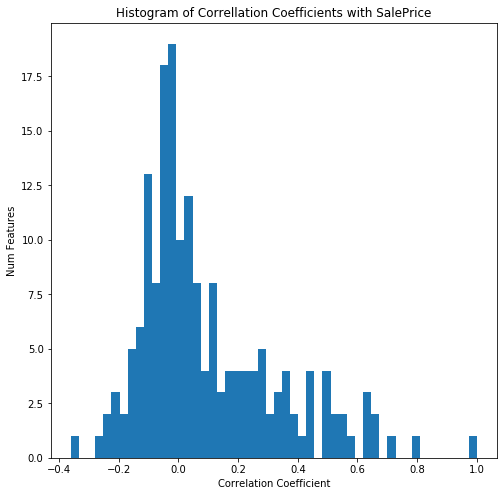

In [13]:
# inspect correlations of new features
corr = processed.corr()
corr['SalePrice']
fig, ax = plt.subplots(figsize=(8, 8))
ax.hist(corr['SalePrice'], bins = 50)
ax.set_title('Histogram of Correllation Coefficients with SalePrice')
ax.set_xlabel('Correlation Coefficient')
ax.set_ylabel('Num Features')
fig.show()

Seeing the above, our first step is to attempt to create our model in an automated way using the correlations seen above. Using a linear regression with only the features with correlation far from zero drastically reduces our error metric as expected. We will notice later on that with just this simple feature selection technique we have achieved a very good relative error score.

In [14]:
# try choosing features based on corr coeficients with SalePrice
colsToUse = corr.index[(corr['SalePrice'] > 0.3) | (corr['SalePrice'] < -0.3)].tolist()
X = processed[colsToUse].drop(['SalePrice'], axis=1)
y = processed['SalePrice']
lm = LinearRegression()
lm.fit(X,y)
X_test = processed_test[colsToUse].drop(['SalePrice'], axis=1)
y_pred = lm.predict(X_test)
y_test = processed_test['SalePrice']
err = get_error(y_test, y_pred)
print(err)
results.append(['linear corr cols', err])

0.17308336258997753


Next we try our hand at some manual feature selection using the correlation coefficients generated above. First we visualize the correlations of the features with the top coefficients and then we make manual selections to try to produce an even better model.

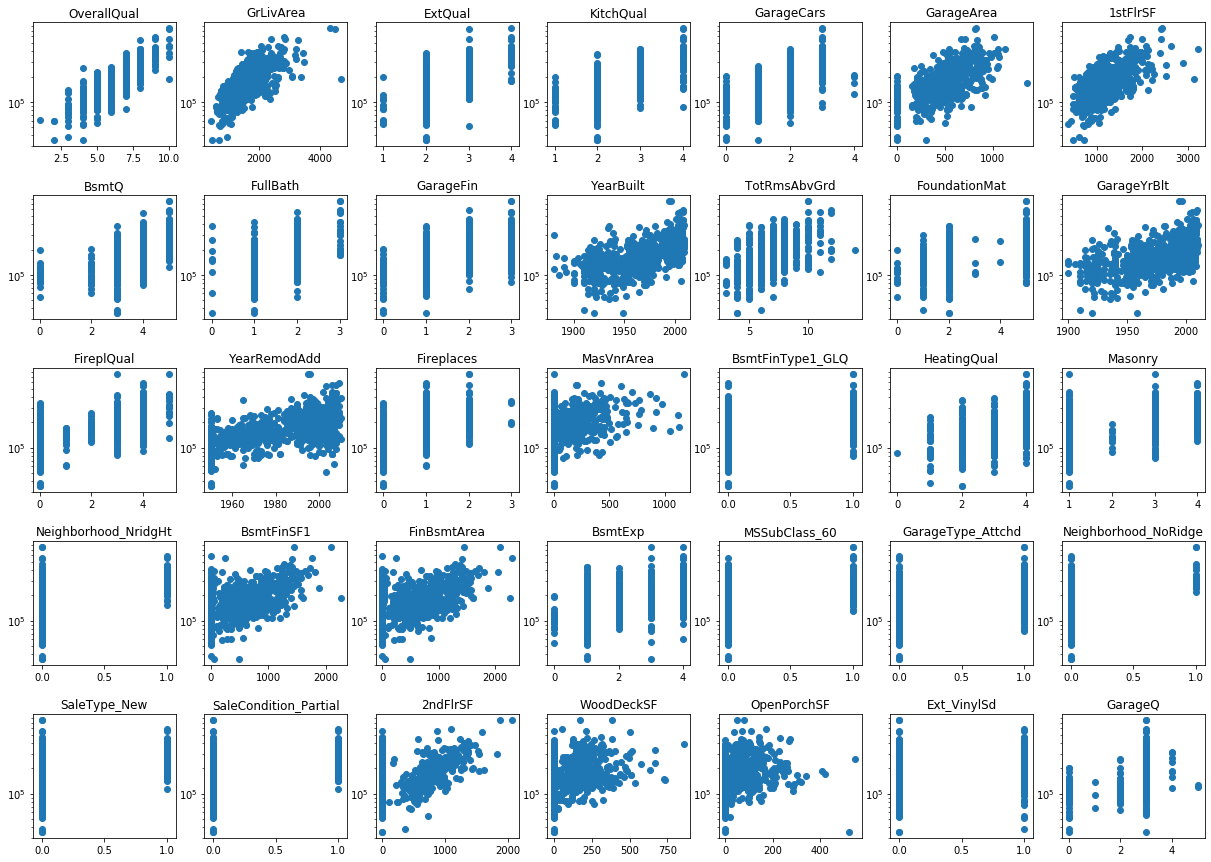

In [15]:
# visualize features with highest correllations
num_cols = 35
topcorrs = corr[['SalePrice']].sort_values('SalePrice', ascending=False).index[1:num_cols+1]

fig = plt.figure(figsize=(21,15))
plt.subplots_adjust(hspace=0.4)
for idx,col in enumerate(topcorrs, start=1):
  ax = fig.add_subplot(5,7,idx)
  ax.scatter(processed[col], processed['SalePrice'])
  plt.yscale('log') # added after the fact because plots had larger dispersion at high SalePrice
  ax.set_title(col)
fig.show()

After looking at the plots above, from here on we predict to log(SalePrice) in our linear models. First, for comparison, we construct a basic model using all 35 features with the highest correlation with the SalePrice variable.

In [16]:
# take all top 35 features
X = processed[topcorrs]
y = processed[['SalePrice']]
y_log = y.apply(lambda x: log(x), axis=1)
lm = LinearRegression()
lm.fit(X,y_log)
X_test = processed_test[topcorrs]
y_pred_log = lm.predict(X_test)
y_pred = np.array([exp(x) for x in y_pred_log])
y_test = processed_test['SalePrice']
err = get_error(y_test, y_pred)
print(err)
results.append(['top corrs linear (vs log(SP))', err])

0.18002182273141681


Next we'd like to do some manual feature selection. Before we do this we inspect more closely the LotArea variable. We would think this variable has a high correlation with the SalePrice, but it is not showing up in our list of top correlations. Let inspect the scatter plot:

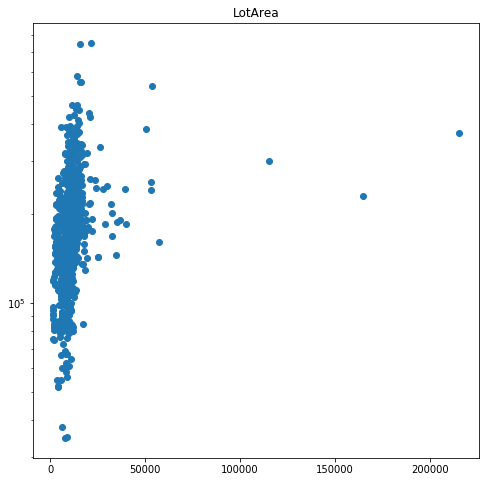

In [18]:
# visualize features with highest correllations
colsToVisualize = ['LotArea']

fig = plt.figure(figsize=(8,8))
plt.subplots_adjust(hspace=0.4)
for idx,col in enumerate(colsToVisualize, start=1):
  ax = fig.add_subplot(1,1,idx)
  ax.scatter(processed[col], processed['SalePrice'])
  plt.yscale('log') # added after the fact because plots had larger dispersion at high SalePrice
  ax.set_title(col)
fig.show()

We see that we have some major outliers, let's remove these and investigate the change in the correlation:

In [26]:
print('correlation with outliers:' + str(corr[['SalePrice']].loc['LotArea', :]))

correlation with outliers:SalePrice    0.262708
Name: LotArea, dtype: float64


correlation without outliers:SalePrice    0.363627
Name: LotArea, dtype: float64


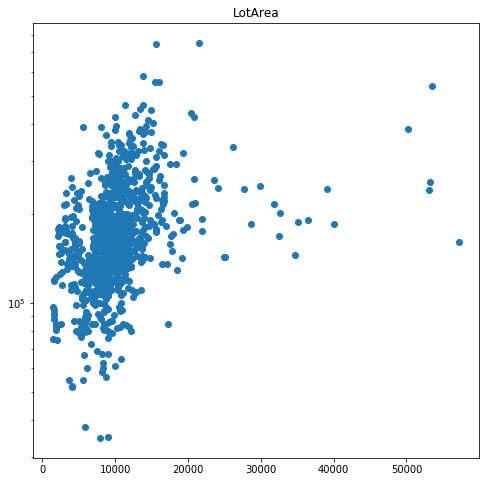

In [36]:
noLotAreaOutliers = processed.loc[processed['LotArea'] < 100000, :]
colsToVisualize = ['LotArea']

fig = plt.figure(figsize=(8,8))
plt.subplots_adjust(hspace=0.4)
for idx,col in enumerate(colsToVisualize, start=1):
  ax = fig.add_subplot(1,1,idx)
  ax.scatter(noLotAreaOutliers[col], noLotAreaOutliers['SalePrice'])
  plt.yscale('log') # added after the fact because plots had larger dispersion at high SalePrice
  ax.set_title(col)
fig.show()
newCorr = noLotAreaOutliers.corr()
print('correlation without outliers:' + str(newCorr[['SalePrice']].loc['LotArea', :]))

Now we do some manual feature selection and investigate what the difference in our error is when we include this filter vs not:

In [37]:
# choose features based manually based on scatter plots
colsToUse_scatter = ['OverallQual', 'GrLivArea', '1stFlrSF', 'FinBsmtArea', 
             'Neighborhood_NridgHt', 'Neighborhood_NoRidge', 'WoodDeckSF', 
             '2ndFlrSF', 'LotArea']
X = processed[colsToUse_scatter]
y = processed[['SalePrice']]
y_log = y.apply(lambda x: log(x), axis=1)
lm = LinearRegression()
lm.fit(X,y_log)
X_test = processed_test[colsToUse_scatter]
y_pred_log = lm.predict(X_test)
y_pred = np.array([exp(x) for x in y_pred_log])
y_test = processed_test['SalePrice']
err = get_error(y_test, y_pred)
print(err)
results.append(['scatter visual linear (vs log(SP))', err])

0.2027896940971626


In [38]:
# choose features based manually based on scatter plots
colsToUse_scatter = ['OverallQual', 'GrLivArea', 'ExtQual', 'KitchQual', 'GarageArea', 
             '1stFlrSF', 'BsmtQ', 'FullBath', 'GarageFin', 'TotRmsAbvGrd', 
             'YearRemodAdd', 'MasVnrArea', 'FinBsmtArea', 
             'Neighborhood_NridgHt', 'Neighborhood_NoRidge', 'WoodDeckSF', 
             '2ndFlrSF', 'LotArea']
X = noLotAreaOutliers[colsToUse_scatter]
y = noLotAreaOutliers[['SalePrice']]
y_log = y.apply(lambda x: log(x), axis=1)
lm = LinearRegression()
lm.fit(X,y_log)
X_test = processed_test[colsToUse_scatter]
y_pred_log = lm.predict(X_test)
y_pred = np.array([exp(x) for x in y_pred_log])
y_test = processed_test['SalePrice']
err = get_error(y_test, y_pred)
print(err)
results.append(['scatter visual linear filered LotArea (vs log(SP))', err])

0.18760267424433563


We see that this filter did help increase our accuracy. A follow up to this project would be to do similar analysis on other features with outliers to try to further improve accuracy.

Next we attempt to choose features based on intuition rather than our correlation based approach above:

In [40]:
# manually choose features based on intuition
colsToUse_intuit = ['LotArea','OverallQual','OverallCond','YearRemodAdd','1stFlrSF',
 '2ndFlrSF','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces',
 'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',
 'PoolArea','Utils','PosProxScore','NegProxScore','ExtQual','ExtCond','BsmtQ',
 'BsmtC','HeatingQual','CentrlAir','Elec','KitchQual','HomeFunct','FireplQual',
 'GarageQ','GarageC','Neighborhood_Blmngtn','Neighborhood_BrDale',
 'Neighborhood_BrkSide','Neighborhood_ClearCr','Neighborhood_CollgCr','Neighborhood_Crawfor',
 'Neighborhood_Edwards','Neighborhood_Gilbert','Neighborhood_IDOTRR','Neighborhood_MeadowV',
 'Neighborhood_Mitchel','Neighborhood_NAmes','Neighborhood_NPkVill','Neighborhood_NWAmes',
 'Neighborhood_NoRidge','Neighborhood_NridgHt','Neighborhood_OldTown','Neighborhood_SWISU',
 'Neighborhood_Sawyer','Neighborhood_SawyerW','Neighborhood_Somerst','Neighborhood_StoneBr',
 'Neighborhood_Timber','Neighborhood_Veenker',
 ]
X = processed[colsToUse_intuit]
y = processed[['SalePrice']]
y_log = y.apply(lambda x: log(x), axis=1)
lm = LinearRegression()
lm.fit(X,y_log)
X_test = processed_test[colsToUse_intuit]
y_pred_log = lm.predict(X_test)
y_pred = np.array([exp(x) for x in y_pred_log])
y_test = processed_test['SalePrice']
err = get_error(y_test, y_pred)
print(err)
results.append(['intuitive linear (vs log(SP))', err])

0.1572381379478021


Here we see a better accuracy than we have seen yet, indicating that an intuition based approach has a lot to offer over some of the more automated but less customized pure machine learning methods.

Next we see if we can improve upon our correlation based approach by applying PCA to our preprocessed dataset. First we examine the relationship between percentage of explained variance and the number of pca components included:

In [0]:
def get_expvar_by_ncomp(pca):
  total_exp_var = 0.0
  points = np.empty([pca.n_components_, 2])
  for (i, var) in enumerate(pca.explained_variance_ratio_):
    total_exp_var += var
    points[i,0] = i
    points[i,1] = total_exp_var
  return points


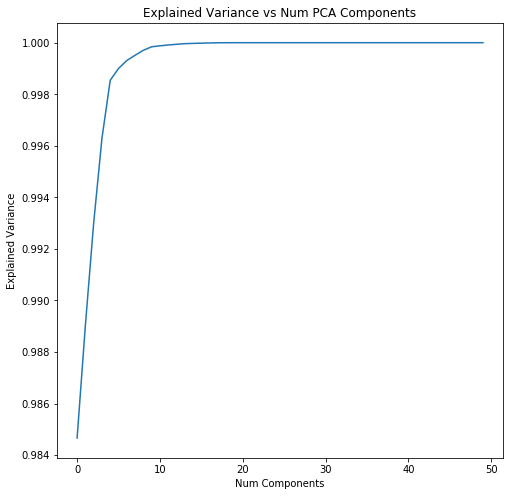

In [43]:
# try PCA with different values of n_components
pca = PCA(n_components=50)
pca.fit(processed.drop(['SalePrice'], axis=1))
points = get_expvar_by_ncomp(pca)
x, y = points.T

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(x, y)
ax.set_title('Explained Variance vs Num PCA Components')
ax.set_xlabel('Num Components')
ax.set_ylabel('Explained Variance')
fig.show()

We see that with less than 10 components we quickly reach over 99.9% explained variance in our dataset. Let's examine the results of applying PCA for feature selection using just a small subset of components. Through testing various number of components I have found that 20 seems to yield the best results striking a balance between over fitting and included features. We see in the model following that the error increases significantly when we include a large number of components likely due to overfitting.

In [56]:
# use PCA to reduce feature space dramatically
pca = PCA(n_components=20)
X = pca.fit_transform(processed.drop(['SalePrice'], axis=1))
y = processed[['SalePrice']]
y_log = y.apply(lambda x: log(x), axis=1)
lm = LinearRegression()
lm.fit(X,y_log)
X_test = pca.transform(processed_test.drop(['SalePrice'], axis=1))
y_pred_log = lm.predict(X_test)
y_pred = np.array([exp(x) for x in y_pred_log])
y_test = processed_test['SalePrice']
err = get_error(y_test, y_pred)
print(err)
results.append(['pca (vs log(SP))', err])

0.22044690536858846


In [0]:
# PCA error increases dramatically at the 22nd component and above, why is that?
pca = PCA(n_components=50)
X = pca.fit_transform(processed.drop(['SalePrice'], axis=1))
y = processed[['SalePrice']]
y_log = y.apply(lambda x: log(x), axis=1)
lm = LinearRegression()
lm.fit(X,y_log)
X_test = pca.transform(processed_test.drop(['SalePrice'], axis=1))
y_pred_log = lm.predict(X_test)
y_pred = np.array([exp(x) for x in y_pred_log])
y_test = processed_test['SalePrice']
err = get_error(y_test, y_pred)
print(err)
results.append(['bad pca (vs log(SP))', err])

14.188795718733877


Next we try a few other advanced regression techniques to see if any can produce better results than our simple Linear Regression model. We see that none produce better results than our manually selected Linear regression model shown above. A follow up to this project could explore more variations on these more advanced models to understand what tuning can be done to improve performance.

In [57]:
# Support Vector Regression
svr = SVR(gamma='scale', kernel='rbf')
X = processed.drop(['SalePrice'], axis=1)
y = processed[['SalePrice']]
y_log = y.apply(lambda x: log(x), axis=1)
svr.fit(X, y_log)
X_test = processed_test.drop(['SalePrice'], axis=1)
y_pred_log = svr.predict(X_test)
y_pred = np.array([exp(x) for x in y_pred_log])
y_test = processed_test['SalePrice']
err = get_error(y_test, y_pred)
print(err)
results.append(['SVR (vs log(SP))', err])

0.2322264729707224


In [58]:
# lasso 
lasso = Lasso(alpha=0.01, max_iter=100000)
X = processed.drop(['SalePrice'], axis=1)
y = processed[['SalePrice']]
y_log = y.apply(lambda x: log(x), axis=1)
lasso.fit(X,y_log)
X_test = processed_test.drop(['SalePrice'], axis=1)
y_pred_log = lasso.predict(X_test)
y_pred = np.array([exp(x) for x in y_pred_log])
y_test = processed_test['SalePrice']
err = get_error(y_test, y_pred)
print(err)
results.append(['Lasso (vs log(SP))', err])

0.20322693150593818


In [59]:
# lasso with model selection
lasso = LassoCV(cv=10, alphas=np.array([n/1000.0 for n in range(1,100,1)]), max_iter=100000)
X = processed.drop(['SalePrice'], axis=1)
y = processed[['SalePrice']]
y_log = y.apply(lambda x: log(x), axis=1)
lasso.fit(X,y_log)
X_test = processed_test.drop(['SalePrice'], axis=1)
y_pred_log = lasso.predict(X_test)
y_pred = np.array([exp(x) for x in y_pred_log])
y_test = processed_test['SalePrice']
err = get_error(y_test, y_pred)
print(err)
results.append(['LassoCV (vs log(SP))', err])

0.22656484050465367


Finally we attempt to train a neural net on this training dataset. We find that the results of the neural network are worse than those of the linear regression with manually selected features. This shows one of the downsides of the neural network based approach: it requires a lot of tuning in order to produce a more effective model than simpler methods. Even the simple neural network below takes an order of magnitude longer to train, not to mention the manual tuning into the number of layers and size of each layer. This leads us to believe that given limited time resources the simple linear regression gives us a better bang for our buck.

In [60]:
# neural net on preprocessed features
net = MLPRegressor(hidden_layer_sizes=(50,50), max_iter=10000)
X = processed.drop(['SalePrice'], axis=1)
y = processed['SalePrice']
net.fit(X, y)
X_test = processed_test.drop(['SalePrice'], axis=1)
y_pred = net.predict(X_test)
y_test = processed_test['SalePrice']
err = get_error(y_test, y_pred)
print(err)
results.append(['neural net preprocessed', err])

0.20294831953868483


In [61]:
# neural net on simple one-hot features
net = MLPRegressor(hidden_layer_sizes=(50,50), max_iter=10000)
dummies = pd.get_dummies(train_data).dropna()
X = dummies.drop(['SalePrice', 'Id'], axis=1)
y = dummies['SalePrice']
net.fit(X,y)
dummies_test = pd.get_dummies(test_data).dropna()
dummies_test = fix_cols(dummies, dummies_test)
X_test = dummies_test.drop(['SalePrice', 'Id'], axis=1)
y_pred = net.predict(X_test)
err = get_error(dummies_test['SalePrice'], y_pred)
print(err)
results.append(['neural net one-hot encoded', err])

0.2102308634620406


Finally for comparison's sake we come back to our linear regresion models with all features included predicting against the log of our SalePrice variable this time.

In [62]:
# regression on log(SalePrice) with all dummies
dummies = pd.get_dummies(train_data).dropna()
X = dummies.drop(['SalePrice', 'Id'], axis=1)
y = dummies[['SalePrice']]
y_log = y.apply(lambda x: log(x), axis=1)
lm = LinearRegression()
lm.fit(X,y_log)
dummies_test = pd.get_dummies(test_data).dropna()
dummies_test = fix_cols(dummies, dummies_test)
X_test = dummies_test.drop(['SalePrice', 'Id'], axis=1)
y_pred_log = lm.predict(X_test)
y_pred = np.array([exp(x) for x in y_pred_log])
err = get_error(dummies_test['SalePrice'], y_pred)
print(err)
results.append(['dummy linear (vs log(SP))', err])

0.4853525960836292


In [63]:
# regression on log(SalePrice) with all preprocessed feats
X = processed.drop(['SalePrice'], axis=1)
y = processed[['SalePrice']]
y_log = y.apply(lambda x: log(x), axis=1)
lm = LinearRegression()
lm.fit(X,y_log)
X_test = processed_test.drop(['SalePrice'], axis=1)
y_pred_log = lm.predict(X_test)
y_pred = np.array([exp(x) for x in y_pred_log])
y_test = processed_test['SalePrice']
err = get_error(y_test, y_pred)
print(err)
results.append(['processed linear (vs log(SP))', err])

6.485710122265511


In [0]:
pd.DataFrame(results, columns=['Method', 'MeanSquaredLogError']).sort_values('MeanSquaredLogError')

,Method,MeanSquaredLogError
5,intuitive linear (vs log(SP)),0.123676
3,top corrs linear (vs log(SP)),0.137465
4,scatter visual linear (vs log(SP)),0.142129
9,Lasso (vs log(SP)),0.154287
2,linear corr cols,0.157462
10,LassoCV (vs log(SP)),0.161438
6,pca (vs log(SP)),0.172419
11,neural net preprocessed,0.188654
12,neural net one-hot encoded,0.199638
8,SVR (vs log(SP)),0.228101


From the above analysis we notice a few key things to point out:


*   The algorithm with the best accuracy is the intuitive linear regression model
*   Simple LinearRegression models work better than more complex ones like Neural Networks in many cases (especially when you don't have the time to do the necessary fine tuning neural networks require)
*   Best to have domain knowledge
*   "Black Box" Algorithms are hard to debug
*   Large feature spaces are hard to debug and could decrease accuracy

This gives us some good intuition about the type of models that work well for this problem and the relative level of effort needed for each to produce good results. Our main finding is that inuitive approaches are very practical and seem to produce better results than simple models where we throw in all our features into a black-box type algorithm like a neural network.




## Appendix A
### Initial EDA

Below is my original step by step analysis/processing of each feature. This has since been modified and added to the preprocess_data function but is kept here for reference.

In [0]:
# drop Id column it shouldn't matter
train_data.drop('Id', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
# MSSubClass is an int but it really represents a set of categories
# the information in the categories is mostly contained in other features so let's drop it
train_data.drop('MSSubClass', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
train_data['MSZoning'].unique()

array(['RL', 'RM', 'RH', 'FV', 'C (all)'], dtype=object)

In [0]:
res_zones = ['FV','RH','RL','RP','RM']
train_data['ResZoned'] = train_data['MSZoning'].isin(res_zones)
train_data['Density'] = train_data.apply(lambda x: 4, axis= 1)
train_data.loc[train_data['MSZoning'].isin(['RL', 'RP', 'A']), 'Density'] = 1
train_data.loc[train_data['MSZoning'].isin(['RM', 'FV']), 'Density'] = 2
train_data.loc[train_data['MSZoning'] == 'RH', 'Density'] = 3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [0]:
train_data.drop('MSZoning', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
le = LabelEncoder()

In [0]:
train_data['RoadType'] = train_data[['Street']].apply(lambda col: le.fit_transform(col))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
train_data.drop('Street', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
train_data['HasAlley'] = train_data['Alley'].isin(['Grvl','Pave'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
train_data.drop('Alley', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
oeShape = OrdinalEncoder(categories=[['Reg', 'IR1', 'IR2', 'IR3']])
train_data['Shape'] = oeShape.fit_transform(train_data[['LotShape']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
train_data.drop('LotShape', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
train_data.drop('LandContour', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
oeUtil = OrdinalEncoder(categories=[['ELO', 'NoSeWa', 'NoSewr', 'AllPub']])
train_data['Utils'] = oeUtil.fit_transform(train_data[['Utilities']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
train_data.drop('Utilities', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
train_data['IsCulDSac'] = train_data['LotConfig'] == 'CulDSac'
train_data['HasFrontage'] = train_data['LotConfig'].isin(['FR2', 'FR3'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
train_data.drop('LotConfig', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
oeSlope = OrdinalEncoder(categories=[['Gtl', 'Mod', 'Sev']])
train_data['Slope'] = oeSlope.fit_transform(train_data[['LandSlope']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
train_data.drop('LandSlope', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
train_data = pd.concat([train_data, pd.get_dummies(train_data['Neighborhood'])], axis=1)

In [0]:
train_data.drop('Neighborhood', axis=1, inplace=True)

In [0]:
def get_prox_num(x):
  pos = 0
  neg = 0
  if(x['Condition1'] == 'RRAn' or x['Condition1'] == 'RRAe'  or x['Condition2'] == 'RRAn' or x['Condition2'] == 'RRAe'):
    neg = -2
  elif(x['Condition1'] == 'RRNn' or x['Condition1'] == 'RRNe'  or x['Condition2'] == 'RRNn' or x['Condition2'] == 'RRNe'):
    neg = -1
  
  if(x['Condition1'] == 'PosA'  or x['Condition2'] == 'PosA'):
    pos = 2
  elif(x['Condition1'] == 'PosN'  or x['Condition2'] == 'PosN'):
    pos = 1

  return pos + neg

In [0]:
train_data['ProximityScore'] = train_data.apply(lambda x: get_prox_num(x), axis=1)

In [0]:
train_data.drop(['Condition1', 'Condition2'], axis=1, inplace=True)

In [0]:

oeBldg = OrdinalEncoder(categories=[['2FmCon', 'TwnhsI', 'TwnhsE', 'Duplx', '1Fam']])
train_data.loc[train_data['BldgType'] == '2fmCon', 'BldgType'] = '2FmCon'
train_data.loc[train_data['BldgType'] == 'Twnhs', 'BldgType'] = 'TwnhsI'
train_data.loc[train_data['BldgType'] == 'Duplex', 'BldgType'] = 'Duplx'
train_data['Bldg'] = oeBldg.fit_transform(train_data[['BldgType']])

In [0]:
train_data.drop('BldgType', axis=1, inplace=True)

In [0]:
oeHouse = OrdinalEncoder(categories=[['1Story', '1.5Unf', '1.5Fin', 'SFoyer', 'SLvl', '2Story', '2.5Unf', '2.5Fin']])
train_data['House'] = oeHouse.fit_transform(train_data[['HouseStyle']])

In [0]:
train_data.drop('HouseStyle', axis=1, inplace=True)

In [0]:
print(train_data['YearBuilt'].min())
print(train_data['YearRemodAdd'].min())
print(train_data['YearBuilt'].max())
print(train_data['YearRemodAdd'].max())

1875
1950
2010
2010


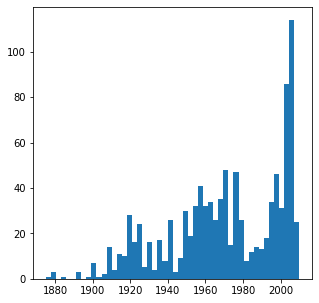

In [0]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(train_data['YearBuilt'], bins = 50)
fig.show()

In [0]:
train_data.drop('RoofStyle', axis=1, inplace=True)

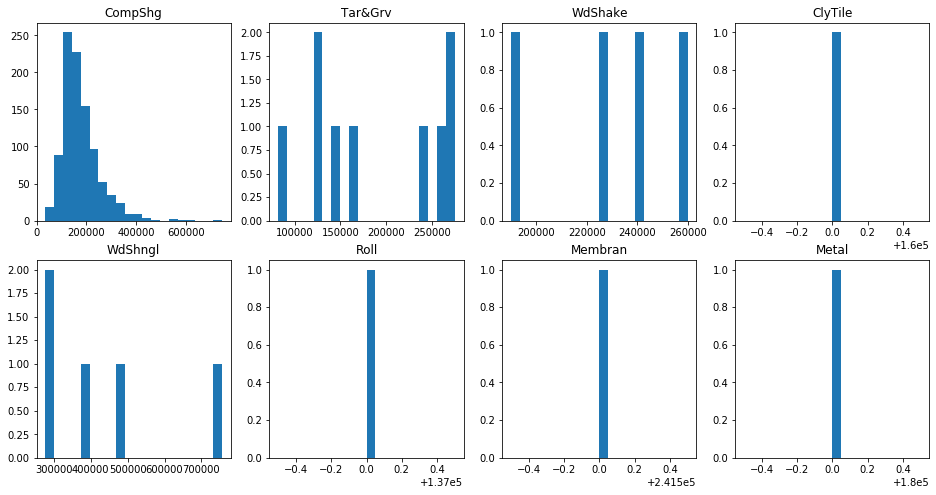

In [0]:
fig = plt.figure(figsize=(16,8))
mats = train_data['RoofMatl'].unique()
for idx,mat in enumerate(mats, start=1):
  ax = fig.add_subplot(2,4,idx)
  ax.hist(train_data.loc[train_data['RoofMatl'] == mat, 'SalePrice'], bins = 20)
  ax.set_title(mat)
fig.show()

In [0]:
print(len(train_data.loc[train_data['RoofMatl'] == 'Metal']))
print(len(train_data.loc[train_data['RoofMatl'] == 'Membran']))
print(len(train_data.loc[train_data['RoofMatl'] == 'Roll']))
print(len(train_data.loc[train_data['RoofMatl'] == 'ClyTile']))

1
1
1
1


In [0]:
# not enough distribution on the values besides CompShg
train_data.drop('RoofMatl', axis=1, inplace=True)

In [0]:
ext_dummies = pd.get_dummies(train_data[['Exterior1st', 'Exterior2nd']], {'Exterior1st': 'Ext', 'Exterior2nd': 'Ext2'}, columns=['Exterior1st', 'Exterior2nd'])

rmvCols = []
for col in ext_dummies.columns:
  if 'Ext2' in col:
    mat = col.split('_')[1]
    if mat == 'Brk Cmn':
      mat = 'BrkComm'
    if mat == 'CmentBd':
      mat = 'CemntBd'
    if mat == 'Wd Shng':
      mat = 'WdShing'
    extCol = 'Ext_' + mat
    if extCol not in ext_dummies.columns:
      ext_dummies[extCol] = ext_dummies[col]
    ext_dummies[extCol] = ext_dummies[extCol] | ext_dummies[col]
    rmvCols.append(col)
ext_dummies.drop(rmvCols, axis=1, inplace=True)

train_data = pd.concat([train_data, ext_dummies], axis=1)

In [0]:
train_data.drop(['Exterior1st', 'Exterior2nd'], axis=1, inplace=True)

In [0]:
train_data.loc[train_data['MasVnrType'].isna(), 'MasVnrType'] = 'None'
oeMasonry = OrdinalEncoder(categories=[['CBlock', 'None', 'BrkCmn', 'BrkFace', 'Stone']])
train_data['Masonry'] = oeMasonry.fit_transform(train_data[['MasVnrType']])

In [0]:
train_data.drop('MasVnrType', axis=1, inplace=True)

In [0]:
train_data.loc[train_data['MasVnrArea'].isna(), 'MasVnrArea'] = 0

In [0]:
oeExtQ = OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex']])
train_data['ExtQual'] = oeExtQ.fit_transform(train_data[['ExterQual']])
train_data['ExtCond'] = oeExtQ.fit_transform(train_data[['ExterCond']])

In [0]:
train_data.drop(['ExterQual', 'ExterCond'], axis=1, inplace=True)

CBlock mean= 151068.08735632183
Stone mean= 178595.8
PConc mean= 220316.32488479262
BrkTil mean= 130749.92523364486
Wood mean= 196500.0
Slab mean= 109386.76470588235


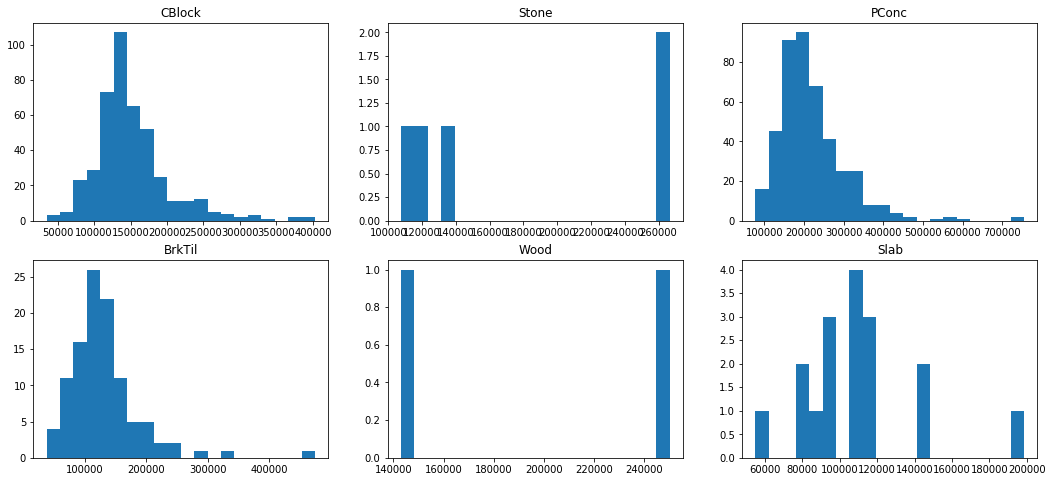

In [0]:
fig = plt.figure(figsize=(18,8))
mats = train_data['Foundation'].unique()
for idx,mat in enumerate(mats, start=1):
  ax = fig.add_subplot(2,3,idx)
  ax.hist(train_data.loc[train_data['Foundation'] == mat, 'SalePrice'], bins = 20)
  ax.set_title(mat)
  print(mat + ' mean= ' + str(train_data.loc[train_data['Foundation'] == mat, 'SalePrice'].mean()))
fig.show()

In [0]:
oeFound = OrdinalEncoder(categories=[['Slab', 'BrkTil', 'CBlock', 'Stone', 'Wood', 'PConc']])
train_data['FoundationMat'] = oeFound.fit_transform(train_data[['Foundation']])

In [0]:
train_data.drop('Foundation', axis=1, inplace=True)

In [0]:
train_data.loc[train_data['BsmtQual'].isna(), 'BsmtQual'] = 'NA'
train_data.loc[train_data['BsmtCond'].isna(), 'BsmtCond'] = 'NA'
oeBsmtQ = OrdinalEncoder(categories=[['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])
train_data['BsmtQ'] = oeBsmtQ.fit_transform(train_data[['BsmtQual']])
train_data['BsmtC'] = oeBsmtQ.fit_transform(train_data[['BsmtCond']])

In [0]:
train_data.drop(['BsmtQual', 'BsmtCond'], axis=1, inplace=True)

In [0]:
train_data.loc[train_data['BsmtExposure'].isna(), 'BsmtExposure'] = 'NA'
oeBsmtExp = OrdinalEncoder(categories=[['NA', 'No', 'Mn', 'Av', 'Gd']])
train_data['BsmtExp'] = oeBsmtExp.fit_transform(train_data[['BsmtExposure']])

In [0]:
train_data.drop('BsmtExposure', axis=1, inplace=True)

In [0]:
train_data['FinBsmtArea'] = train_data['TotalBsmtSF'] - train_data['BsmtUnfSF']

In [0]:
train_data.drop(['BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtUnfSF'], axis=1, inplace=True)

In [0]:
oeHeat = OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex']])
train_data['HeatingQual'] = oeHeat.fit_transform(train_data[['HeatingQC']])

In [0]:
train_data.drop(['HeatingQC', 'Heating'], axis=1, inplace=True)

In [0]:
train_data['CentrlAir'] = train_data[['CentralAir']].apply(lambda col: le.fit_transform(col))

In [0]:
train_data.drop('CentralAir', axis=1, inplace=True)

In [0]:
train_data.loc[train_data['Electrical'].isna(), 'Electrical'] = 'NA'
oeElec = OrdinalEncoder(categories=[['NA', 'FuseP', 'FuseF', 'Mix', 'FuseA', 'SBrkr']])
train_data['Elec'] = oeElec.fit_transform(train_data[['Electrical']])

In [0]:
train_data.drop('Electrical', axis=1, inplace=True)

In [0]:
oeKitch = OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex']])
train_data['KitchQual'] = oeKitch.fit_transform(train_data[['KitchenQual']])

In [0]:
train_data.drop('KitchenQual', axis=1, inplace=True)

In [0]:
oeFunc = OrdinalEncoder(categories=[['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']])
train_data['HomeFunct'] = oeFunc.fit_transform(train_data[['Functional']])

In [0]:
train_data.drop('Functional', axis=1, inplace=True)

In [0]:
train_data.loc[train_data['FireplaceQu'].isna(), 'FireplaceQu'] = 'NA'
oeFireQ = OrdinalEncoder(categories=[['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])
train_data['FireplQual'] = oeFireQ.fit_transform(train_data[['FireplaceQu']])

In [0]:
train_data.drop('FireplaceQu', axis=1, inplace=True)

In [0]:
train_data.loc[train_data['GarageQual'].isna(), 'GarageQual'] = 'NA'
train_data.loc[train_data['GarageCond'].isna(), 'GarageCond'] = 'NA'
oeGarage = OrdinalEncoder(categories=[['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])
train_data['GarageQ'] = oeGarage.fit_transform(train_data[['GarageQual']])
train_data['GarageC'] = oeGarage.fit_transform(train_data[['GarageCond']])

In [0]:
train_data.loc[train_data['GarageFinish'].isna(), 'GarageFinish'] = 'NA'
oeGarageFin = OrdinalEncoder(categories=[['NA', 'Unf', 'RFn', 'Fin']])
train_data['GarageFin'] = oeGarageFin.fit_transform(train_data[['GarageFinish']])

In [0]:
train_data.drop(['GarageType','GarageFinish','GarageQual','GarageCond'], axis=1, inplace=True)

In [0]:
oeDrive = OrdinalEncoder(categories=[['N', 'P', 'Y']])
train_data['Driveway'] = oeDrive.fit_transform(train_data[['PavedDrive']])

In [0]:
train_data.drop('PavedDrive', axis=1, inplace=True)

In [0]:
train_data.loc[train_data['PoolQC'].isna(), 'PoolQC'] = 'NA'
oePool = OrdinalEncoder(categories=[['NA', 'Fa', 'TA', 'Gd', 'Ex']])
train_data['PoolQual'] = oePool.fit_transform(train_data[['PoolQC']])

In [0]:
train_data.drop('PoolQC', axis=1, inplace=True)

In [0]:
train_data.loc[train_data['Fence'].isna(), 'Fence'] = 'NA'
oeFence = OrdinalEncoder(categories=[['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']])
train_data['FenceQual'] = oeFence.fit_transform(train_data[['Fence']])

In [0]:
train_data.drop('Fence', axis=1, inplace=True)

In [0]:
train_data = pd.get_dummies(train_data, columns=['MiscFeature', 'SaleType', 'SaleCondition'])

In [0]:
pd.options.display.max_rows = 200
print(train_data.isna().any())
pd.options.display.max_rows = 60

LotFrontage               True
LotArea                  False
OverallQual              False
OverallCond              False
YearBuilt                False
YearRemodAdd             False
MasVnrArea               False
1stFlrSF                 False
2ndFlrSF                 False
LowQualFinSF             False
GrLivArea                False
BsmtFullBath             False
BsmtHalfBath             False
FullBath                 False
HalfBath                 False
BedroomAbvGr             False
KitchenAbvGr             False
TotRmsAbvGrd             False
Fireplaces               False
GarageYrBlt               True
GarageCars               False
GarageArea               False
WoodDeckSF               False
OpenPorchSF              False
EnclosedPorch            False
3SsnPorch                False
ScreenPorch              False
PoolArea                 False
MiscVal                  False
MoSold                   False
YrSold                   False
SalePrice                False
ResZoned

In [0]:
train_data.loc[train_data['LotFrontage'].isna(), 'LotFrontage'] = 0
train_data.loc[train_data['GarageYrBlt'].isna(), 'GarageYrBlt'] = train_data.loc[train_data['GarageYrBlt'].isna(), 'YearBuilt']


In [0]:
X = train_data.drop(['SalePrice'], axis=1)
y = train_data['SalePrice']
lm = LinearRegression()
lm.fit(X,y)
y_pred = lm.predict(X)
sqrt(mean_squared_log_error(y, y_pred))

0.1503808011524099